/home/otsukalab/.local/share/virtualenvs/reparam-cfaYz6qU/lib/python3.6/site-packages/autograd/numpy/numpy_vjps.py:90: RuntimeWarning: overflow encountered in square
  defvjp(anp.tanh,   lambda ans, x : lambda g: g / anp.cosh(x) **2)
/home/otsukalab/.local/share/virtualenvs/reparam-cfaYz6qU/lib/python3.6/site-packages/autograd/tracer.py:48: RuntimeWarning: overflow encountered in cosh
  return f_raw(*args, **kwargs)


CPU times: user 9min 15s, sys: 5min 2s, total: 14min 18s
Wall time: 2min 43s
<bound method DataArray.ffill of <xarray.DataArray 'design' (model: 4, step: 102, y: 64, x: 192)>
array([[[[0.46673301, 0.51397638, 0.57905506, ..., 0.33070087,
          0.36221542, 0.4026471 ],
         [0.45567732, 0.52586269, 0.61873371, ..., 0.30256227,
          0.31669048, 0.34972073],
         [0.43148583, 0.54713175, 0.68106898, ..., 0.2648973 ,
          0.25228037, 0.28569855],
         ...,
         [0.40264142, 0.38775559, 0.33847705, ..., 0.09139649,
          0.10225054, 0.121301  ],
         [0.40852753, 0.38690026, 0.34278662, ..., 0.12911566,
          0.13896386, 0.15093284],
         [0.43769145, 0.40449932, 0.37095185, ..., 0.17131552,
          0.17877439, 0.18635347]],

        [[0.32570931, 0.32682421, 0.34928541, ..., 0.41142309,
          0.3774458 , 0.37108019],
         [0.32446972, 0.33071974, 0.36213739, ..., 0.44145544,
          0.38494404, 0.36366933],
         [0.30731034, 0.3

Text(0.5, 1.02, 'mbb_beam_192x64_0.4')

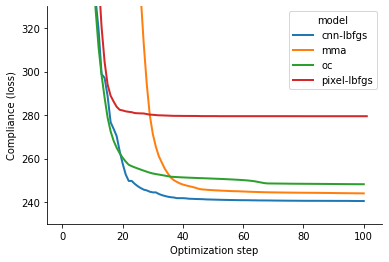

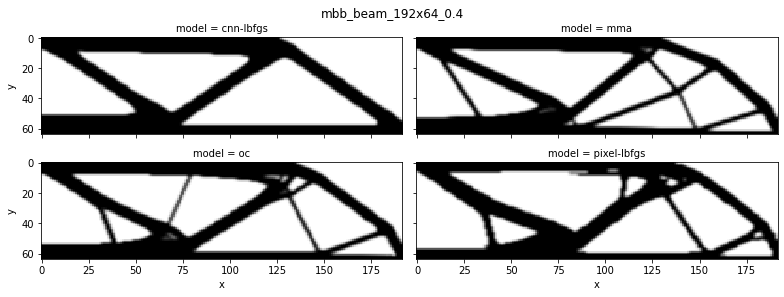

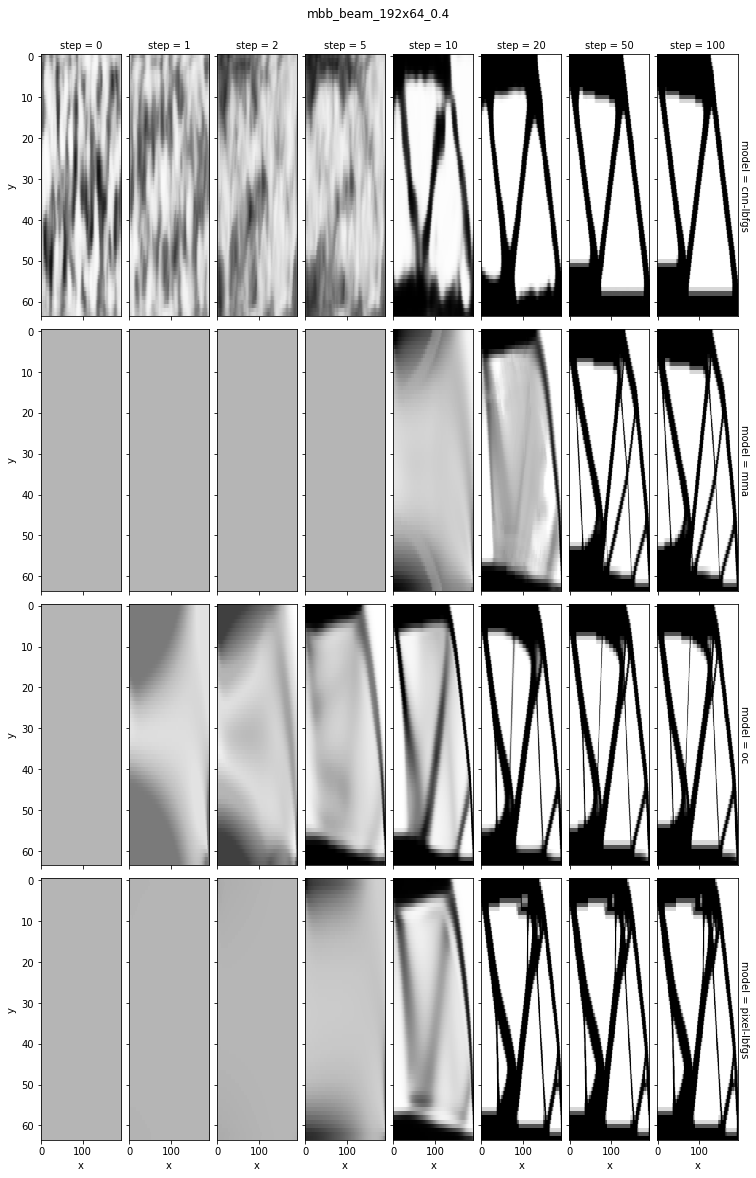

In [2]:
from IPython import display
from PIL import Image
import seaborn
import matplotlib.pyplot as plt
import xarray
import pandas as pd

from neural_structural_optimization.Opt_2DModel_20201206 import pipeline_utils
from neural_structural_optimization.Opt_2DModel_20201206 import problems
from neural_structural_optimization.Opt_2DModel_20201206 import models
from neural_structural_optimization.Opt_2DModel_20201206 import topo_api
from neural_structural_optimization.Opt_2DModel_20201206 import train


def train_all(problem, max_iterations, cnn_kwargs=None):
    args = topo_api.specified_task(problem)
    if cnn_kwargs is None:
        cnn_kwargs = {}

    model = models.PixelModel(args=args)
    ds_mma = train.method_of_moving_asymptotes(model, max_iterations)

    model = models.PixelModel(args=args)
    ds_oc = train.optimality_criteria(model, max_iterations)

    model = models.PixelModel(args=args)
    ds_pix = train.train_lbfgs(model, max_iterations)

    model = models.CNNModel(args=args, **cnn_kwargs)
    ds_cnn = train.train_lbfgs(model, max_iterations)

    dims = pd.Index(['cnn-lbfgs', 'mma', 'oc', 'pixel-lbfgs'], name='model')
    return xarray.concat([ds_cnn, ds_mma, ds_oc, ds_pix], dim=dims)

#"MBB beam with a larger grid"
problem = problems.PROBLEMS_BY_NAME['mbb_beam_192x64_0.4']
max_iterations = 100
%time ds = train_all(problem, max_iterations)

print(ds.design.ffill)
print(ds.design.sel)

ds.loss.transpose().to_pandas().cummin().loc[:200].plot(linewidth=2)
plt.ylim(230, 330)
plt.ylabel('Compliance (loss)')
plt.xlabel('Optimization step')
seaborn.despine()

# the pixel-lbfgs does not run for the full 100 steps (it terminates
# early due to reaching a local minima), so use fill() to forward fill
# to the last valid design.
ds.design.ffill('step').sel(step=100).plot.imshow(
    col='model', x='x', y='y', size=2, aspect=2.5, col_wrap=2,
    yincrease=False, add_colorbar=False, cmap='Greys')
plt.suptitle(problem.name, y=1.02)

ds.design.sel(step=[0, 1, 2, 5, 10, 20, 50, 100]).plot.imshow(
    row='model', col='step', x='x', y='y', size=4, aspect=0.3,
    yincrease=False, add_colorbar=False, cmap='Greys')
plt.subplots_adjust(wspace=0.1, hspace=0.05)
plt.suptitle(problem.name, y=1.02)



